In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from cebra_utils import *
from vit_pytorch import ViT
import pandas as pd

data_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/GRL3_2023-07-13_1'

In [2]:
## Given the path to a tif file, return that as a 3d numpy array
# @param path: path to tif file
# @return: 3d numpy array, first array is time dimension
def load_tif(path):
    img = cv2.imreadmulti(path, flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))[1]
    img = np.array(img)
    return img

## Loads the brain data from a given trial
def load_brain_data(parent_directory, trial_num, type='gcamp'):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/brain/' + type + '.tif')
    data = load_tif(data_path)
    return data

def load_pose_data(parent_directory, trial_num):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/anipose/videos/pose-3d/vid.csv')
    data = pd.read_csv(data_path)
    data = data.to_numpy()
    return data

## Go through all trials and load the brain data for each trial
def load_all_brain_data_trials(parent_directory, type='gcamp'):
    # Get the number of trials
    num_trials = len([x for x in os.listdir(parent_directory) if 'trial_' in x])
    # Load the data
    return np.array([load_brain_data(parent_directory, trial_num, type) for trial_num in range(num_trials)])
    
## Takes a numpy array in and returns a memory mapped numpy array
# @param arr: numpy array to be memory mapped
# @param path: path to save the memory mapped array to
# @return: memory mapped numpy array
def memmap(arr, path):
    # Save the array
    np.save(path, arr)
    # Load the array
    return np.load(path, mmap_mode='r')

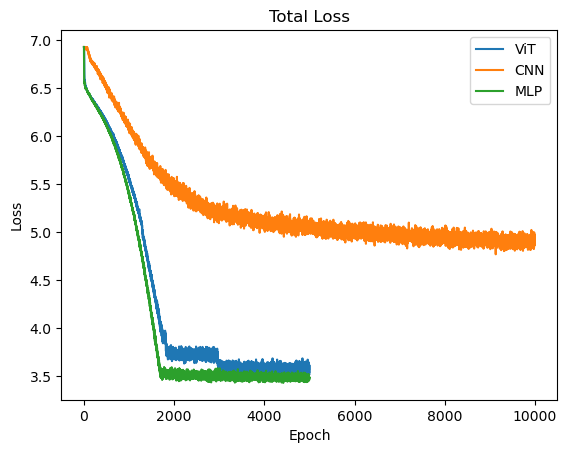

In [3]:
# append parent directory to sys path
sys.path.append('..')
ViT_CEBRA = torch.load('../Models/ViTModel_offset1_embedding2.pth')
CNN_CEBRA = torch.load('../Models/modelCNN.pth')
MLP_CEBRA = torch.load('../Models/MLPModel_offset1_embedding2.pth')
# plot all their losses
plt.plot(ViT_CEBRA.log['total'])
plt.plot(CNN_CEBRA.log['total'])
plt.plot(MLP_CEBRA.log['total'])
plt.legend(['ViT', 'CNN', 'MLP'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.show()

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('ViT Parameters:', count_parameters(ViT_CEBRA))
print('CNN Parameters:', count_parameters(CNN_CEBRA))
print('MLP Parameters:', count_parameters(MLP_CEBRA))

ViT Parameters: 347913
CNN Parameters: 10969
MLP Parameters: 591497


In [40]:
# Load data from different session
data_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-07-07_1'
trial_count = len([x for x in os.listdir(data_path) if 'trial_' in x])
brain_data = [load_brain_data(data_path, x) for x in range(trial_count)]
flattened_brain_data = np.concatenate(brain_data, axis=0)
flattened_brain_data = np.array([cv2.resize(x, (64, 64)) for x in flattened_brain_data])
tensor_data = torch.from_numpy(flattened_brain_data).float()
eval_model = ViT_CEBRA.model.eval()
tensor_data = tensor_data.unsqueeze(2)
print(tensor_data.shape)
embedding_vit = []
num_frames = int(len(flattened_brain_data) / 3) 
for i in range(num_frames):
    embedding_vit.extend(eval_model(tensor_data[i*3: (i+1) * 3].to('cuda')).detach().cpu().numpy())

torch.Size([41472, 64, 1, 64])


In [41]:
One_D_brain_data =  [x.flatten() for x in flattened_brain_data]
One_D_brain_data = np.array(One_D_brain_data)
tensor_one_d = torch.from_numpy(One_D_brain_data).float()
eval_model_mlp = MLP_CEBRA.model.eval()
embedding_mlp = []
embedding_mlp = eval_model_mlp(tensor_one_d[:len(embedding_vit)].to('cuda')).detach().cpu().numpy()

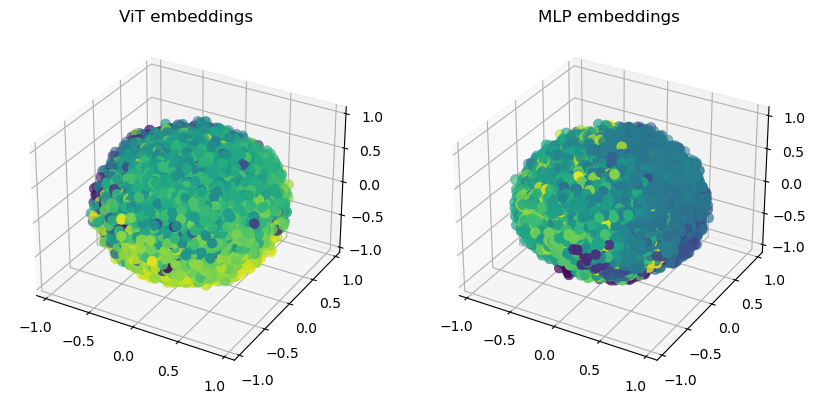

In [42]:
embedding_vit = np.array(embedding_vit)
# make a 3d scatter plot of the first 3 dimensions of the embedding
fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(embedding_vit[:,0], embedding_vit[:,1], embedding_vit[:,2], cmap='viridis', linewidth=0.5, c=(np.arange(len(embedding_vit)) % 288), s=50)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embedding_mlp[:,0], embedding_mlp[:,1], embedding_mlp[:,2], cmap='viridis', linewidth=0.5, c=(np.arange(len(embedding_mlp)) % 288), s=50)
# Label plots, left is ViT, right is MLP
ax.set_title('ViT embeddings')
ax2.set_title('MLP embeddings')
plt.show()

In [43]:
## Reshape embedding vectors from N * 288 x 8  to N x 288 x 8
def reshape_embedding(embedding):
    return np.reshape(embedding, (int(len(embedding) / 288), 288, 8))

batch_vit = reshape_embedding(embedding_vit)
batch_mlp = reshape_embedding(embedding_mlp)

In [105]:
## Load success Failure data from csv with 80:20 test train split
outcome_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/outcomes/FRM1_2023-07-07_1.csv'
outcome_data = pd.read_csv(outcome_path)

## if outcome contains 's' append one to success array  else append 0 to success array
outcomes = outcome_data['Outcome']
# repkace all nan with None
outcomes = [x if x is not np.nan else None for x in outcomes]
success = []
for outcome in outcomes:
    if outcome is not None:
        outcome_split = outcome[1:-1].split(',')
        if 's' in outcome_split:
            success.append([1, 0])
        else:
            success.append([0, 1])
    else:
        success.append([0, 1])

In [106]:
## Load a simple LSTM model which takes in an embedding vector (288 x 8) and classifies it as success or failure
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.hidden = self.init_hidden()
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to('cuda'),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to('cuda'))
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        out = self.fc(lstm_out[:, -1, :])
        return out
    
vit_classifier = LSTM(8, 64, 2, 1)
mlp_classifier = LSTM(8, 64, 2, 1)
vit_classifier = vit_classifier.to('cuda')
mlp_classifier = mlp_classifier.to('cuda')

In [107]:
# Training loop for LSTM
num_epochs = 120
test_split = 0.75
criterion = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(vit_classifier.parameters(), lr=1e-4)
optimizer_mlp = torch.optim.Adam(mlp_classifier.parameters(), lr=1e-4)

# Train vit classifier
vit_log = []
for i in range(num_epochs):
    for j in range(int(len(batch_vit) * test_split)):
        optimizer_vit.zero_grad()
        vit_classifier.hidden = vit_classifier.init_hidden()
        outputs = vit_classifier(torch.from_numpy(batch_vit[j]).float().unsqueeze(0).to('cuda'))
        loss = criterion(outputs, torch.tensor([success[j]]).to('cuda').float())
        loss.backward()
        optimizer_vit.step()
    print('Epoch: {}, Loss: {}'.format(i, loss.item()))
    vit_log.append(loss.item())

mlp_log = []
# Train mlp classifier
for i in range(num_epochs):
    for j in range(int(len(batch_mlp) * test_split)):
        optimizer_mlp.zero_grad()
        mlp_classifier.hidden = mlp_classifier.init_hidden()
        outputs = mlp_classifier(torch.from_numpy(batch_mlp[j]).float().unsqueeze(0).to('cuda'))
        loss = criterion(outputs, torch.tensor([success[j]]).to('cuda').float())
        loss.backward()
        optimizer_mlp.step()
    print('Epoch: {}, Loss: {}'.format(i, loss.item()))
    mlp_log.append(loss.item())

Epoch: 0, Loss: 0.4255174696445465
Epoch: 1, Loss: 0.016024140641093254
Epoch: 2, Loss: 0.016291698440909386
Epoch: 3, Loss: 0.016626838594675064
Epoch: 4, Loss: 0.016894351691007614
Epoch: 5, Loss: 0.017071327194571495
Epoch: 6, Loss: 0.017155935987830162
Epoch: 7, Loss: 0.017376914620399475
Epoch: 8, Loss: 0.019048500806093216
Epoch: 9, Loss: 0.020756062120199203
Epoch: 10, Loss: 0.009189571253955364
Epoch: 11, Loss: 0.011405857279896736
Epoch: 12, Loss: 0.031593792140483856
Epoch: 13, Loss: 0.029140297323465347
Epoch: 14, Loss: 0.03197868540883064
Epoch: 15, Loss: 0.04431784525513649
Epoch: 16, Loss: 0.02624877542257309
Epoch: 17, Loss: 0.023995233699679375
Epoch: 18, Loss: 0.023913413286209106
Epoch: 19, Loss: 0.026849055662751198
Epoch: 20, Loss: 0.006287555210292339
Epoch: 21, Loss: 0.03077339194715023
Epoch: 22, Loss: 0.006303903181105852
Epoch: 23, Loss: 0.010478833690285683
Epoch: 24, Loss: 0.005847253371030092
Epoch: 25, Loss: 0.03005412220954895
Epoch: 26, Loss: 0.0866121426

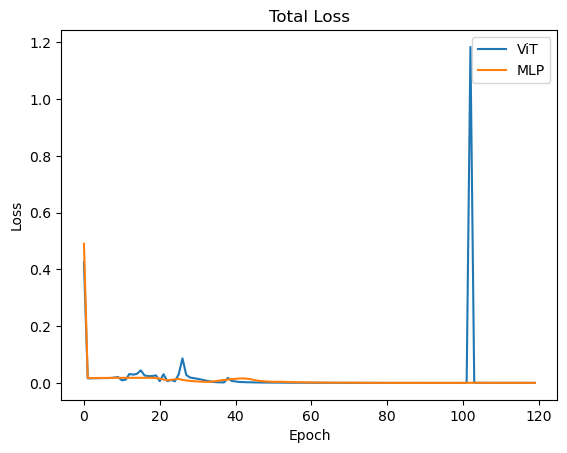

In [108]:
# plot both losses on the same graph
plt.plot(vit_log)
plt.plot(mlp_log)
plt.legend(['ViT', 'MLP'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.show()

ViT Accuracy:  0.9722222222222222
MLP Accuracy:  0.9722222222222222


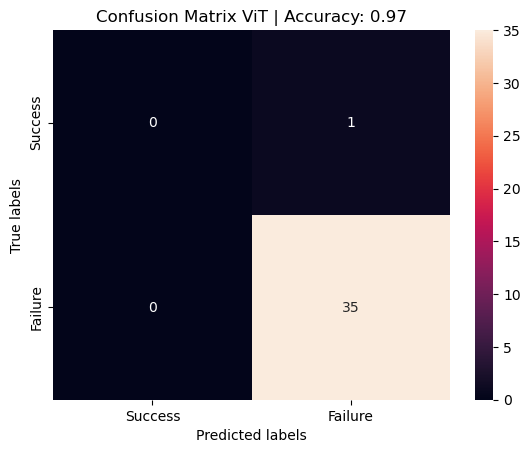

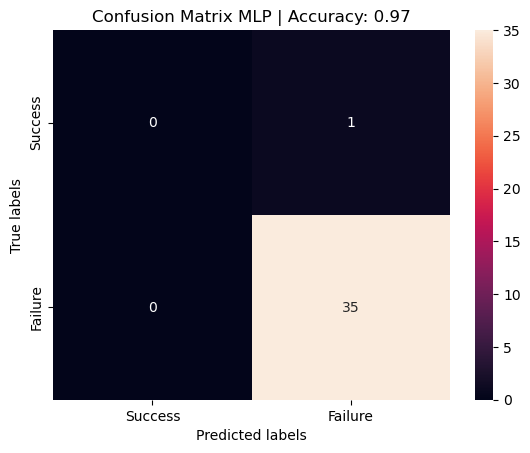

In [109]:
# Test the LSTM on last 20% of data
vit_classifier.eval()
mlp_classifier.eval()
vit_correct = 0
mlp_correct = 0

# test set split
vit_test = batch_vit[int(len(batch_vit) * test_split):]
mlp_test = batch_mlp[int(len(batch_mlp) * test_split):]

# test set labels
vit_test_labels = success[int(len(batch_vit) * test_split):]
mlp_test_labels = success[int(len(batch_mlp) * test_split):]

# test set predictions
vit_predictions = []
mlp_predictions = []
for vit_embed in vit_test:
    vit_classifier.hidden = vit_classifier.init_hidden()
    prediction = (vit_classifier(torch.from_numpy(vit_embed).float().unsqueeze(0).to('cuda')).detach().cpu().numpy())
    # argmax to get the prediction
    vit_predictions.append(np.argmax(prediction))


for mlp_embed in mlp_test:
    mlp_classifier.hidden = mlp_classifier.init_hidden()
    prediction = (mlp_classifier(torch.from_numpy(mlp_embed).float().unsqueeze(0).to('cuda')).detach().cpu().numpy())
    # argmax to get the prediction
    mlp_predictions.append(np.argmax(prediction))

# calculate accuracy
vit_correct = 0
mlp_correct = 0
for i in range(len(vit_predictions)):
    if vit_predictions[i] == np.argmax(vit_test_labels[i]):
        vit_correct += 1
    if mlp_predictions[i] == np.argmax(mlp_test_labels[i]):
        mlp_correct += 1

print('ViT Accuracy: ', vit_correct / len(vit_predictions))
print('MLP Accuracy: ', mlp_correct / len(mlp_predictions))

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix for vit
cm = confusion_matrix(np.argmax(vit_test_labels, axis=1), vit_predictions)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix ViT | Accuracy: ' + str(vit_correct / len(vit_predictions))[:4])
ax.xaxis.set_ticklabels(['Success', 'Failure'])
ax.yaxis.set_ticklabels(['Success', 'Failure'])
plt.show()

# plot confusion matrix for mlp
cm = confusion_matrix(np.argmax(mlp_test_labels, axis=1), mlp_predictions)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix MLP | Accuracy: ' + str(mlp_correct / len(mlp_predictions))[:4])
ax.xaxis.set_ticklabels(['Success', 'Failure'])
ax.yaxis.set_ticklabels(['Success', 'Failure'])
plt.show()

In [78]:
ViT = [child2 for child2 in [child for child in eval_model.children()][0].children()][0]


In [79]:
from vit_pytorch.recorder import Recorder
ViT = Recorder(ViT)


In [80]:
emb, attn = ViT(tensor_data.movedim(1,2)[0:288].to('cuda'))

In [110]:
## Input is attentions maps from ViT recorder
# shape is (depth ,num_heads, num_steps, num_steps)
def rollout(attn):
    # Take the mean across all heads (Subject to change)
    attn_mean = attn.mean(dim=1)

    # add identity adn normalize
    residual_attn = torch.eye(attn_mean.shape[-1]).unsqueeze(0).to('cpu') + attn_mean
    residual_attn = residual_attn / residual_attn.sum(dim=-1).unsqueeze(-1)
    # convert to numpy
    aug_attn_mat = residual_attn.detach().cpu().numpy()
    #Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, 1:].reshape(grid_size, grid_size)
    return mask

In [111]:
tensor_data.squeeze()

tensor([[[ 4.2995e-03,  2.1252e-02,  1.2603e-02,  ...,  1.9152e-02,
           1.4475e-02,  6.0358e-03],
         [ 5.5463e-03,  1.3093e-02,  2.0401e-02,  ...,  2.5145e-02,
           2.6635e-03,  1.1426e-02],
         [ 1.1433e-02, -7.4701e-03,  5.7185e-03,  ...,  4.7023e-02,
           1.3160e-02,  1.2313e-02],
         ...,
         [ 1.6056e-02,  1.0342e-02, -1.2828e-03,  ...,  1.0897e-03,
           3.5380e-03,  1.1075e-04],
         [-3.2109e-03,  4.7136e-03,  9.7806e-03,  ..., -1.5376e-02,
           1.4962e-02, -1.4038e-02],
         [ 2.8423e-02,  1.5679e-02,  2.3562e-02,  ...,  1.8577e-02,
          -9.3556e-03, -8.0798e-03]],

        [[ 1.2922e-02,  5.8613e-03,  1.0304e-02,  ...,  2.8491e-02,
           2.5702e-02,  1.7537e-04],
         [ 4.3184e-03,  6.2180e-03,  1.8897e-02,  ...,  2.1187e-02,
           1.7305e-03, -1.2129e-03],
         [ 1.3930e-02,  1.2788e-02,  8.7452e-03,  ...,  2.1418e-02,
          -1.1252e-02,  3.0448e-03],
         ...,
         [-4.4956e-03, -1

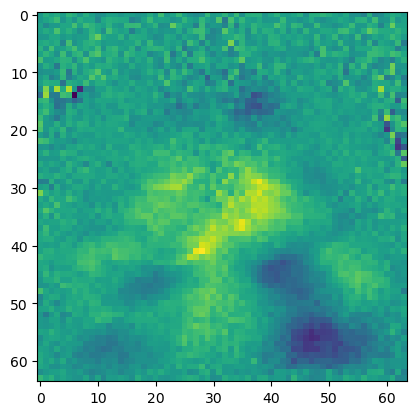

In [112]:
plt.imshow(tensor_data.squeeze()[0].detach().cpu().numpy())

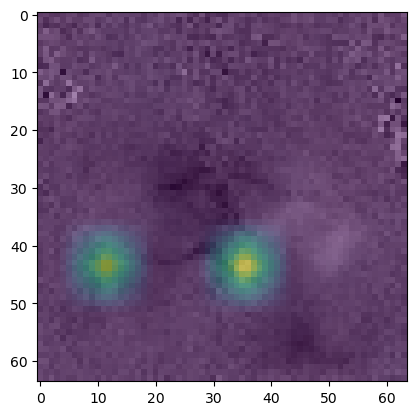

In [113]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
vid_index = 10
masks = [rollout(map.to('cpu')) for map in attn]
attention_video =  np.array([cv2.resize(mask, (64, 64)) for mask in masks])
brain_video =  tensor_data.squeeze()[288 * vid_index: (288 * (vid_index + 1))].detach().cpu().numpy()

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(attention_video)):
    frames.append([plt.imshow(attention_video[i],animated=True), plt.imshow(brain_video[i], cmap='gray', alpha=0.5, animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.mp4')
plt.show()